# Hannah Zhao - Week 2 DenseNet Model wwithout MIL
#### changes include:  implementing a simple MIL model in order to test if the baseline model itself is able to learn tried on a super simple model
##### 1. simple densenet with adaptive pooling, with balanced training and vaidation patches, and ran on 10 epochs
#### overall results:  best results at 75 percent
#### next step: Good improvement, plannning to load this pretrained DenseNet patch classifer features into MIL model to improve performance

In [24]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay


In [25]:
# Define local file paths

# Define your Desktop folder based on your OS; this uses the user's home directory.
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# Path to the filtered patches folder on your Desktop
filtered_patches_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "CMIL_SP2025_Patches_Apr16")

# Path to the CSV file inside Desktop/uni/STAT 390/Hannah Zhao
csv_file_path = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "case_grade_match.csv")

# Directory to store model checkpoints
checkpoint_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "Checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# load labels 
labels = pd.read_csv(csv_file_path)

In [26]:
# === Helper: group patches
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

patches = group_patches(filtered_patches_dir)

# Validation / Test transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Training transform (augmented)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [27]:
# Prepare case split
case_nums = list(patches.keys())
dataset = labels.loc[[(x-1) for x in case_nums]]  # Adjust indexing
valid_classes = [1.0, 3.0, 4.0]
filtered_dataset = dataset[dataset['Class'].isin(valid_classes)]

X = filtered_dataset.Case.reset_index(drop=True)
y = filtered_dataset.Class.reset_index(drop=True)

# All known cases
benign_cases = [2, 21, 22, 25, 34, 45, 53, 77, 78, 79, 85, 90]
highgrade_cases = [1, 3, 9, 12, 38, 49, 55, 60, 62, 70, 89, 92, 98, 99]

# Step 1: Manually assign known train/val cases (must exist in patches)
manual_train = [2, 3, 34, 9]     # 2 benign, 2 high-grade
manual_val   = [78, 92]          # 1 benign, 1 high-grade

# Step 2: Remove any missing cases
existing_case_ids = set(patches.keys())
train_cases = [c for c in manual_train if c in existing_case_ids]
val_cases   = [c for c in manual_val if c in existing_case_ids]

# Step 3: Assign remaining existing benign/high-grade cases to test set
used_cases = set(train_cases + val_cases)
remaining_benign = [c for c in benign_cases if c not in used_cases and c in existing_case_ids]
remaining_highgrade = [c for c in highgrade_cases if c not in used_cases and c in existing_case_ids]
test_cases = remaining_benign + remaining_highgrade

# Confirm distribution
print(f"Train cases: {train_cases}")
print(f"Val cases: {val_cases}")
print(f"Test cases: {test_cases}")


train_patches = {c: patches[c] for c in train_cases if c in patches}
val_patches   = {c: patches[c] for c in val_cases if c in patches}
test_patches  = {c: patches[c] for c in test_cases if c in patches}


# benign_cases = [2, 21, 22, 25, 34, 45, 53, 77, 78, 79, 85, 90]
# highgrade_cases = [1, 3, 9, 12, 38, 49, 55, 60, 62, 70, 89, 92, 98, 99]

# # Split manually or use random
# random.seed(42)
# random.shuffle(benign_cases)
# random.shuffle(highgrade_cases)

# # Choose 3 benign + 3 high-grade for training
# train_cases = benign_cases[:3] + highgrade_cases[:3]

# # Next 2 of each for validation
# val_cases = benign_cases[3:5] + highgrade_cases[3:5]

# # The rest for testing
# test_cases = benign_cases[5:] + highgrade_cases[5:]

# # # === No train_test_split ===
# # train_cases = [77, 34, 89, 9]  # 1 benign + 1 high-grade, 84 -- high grade, 86 -- benign
# # val_cases = [78, 1]        # 1 benign, 2, 92
# # test_cases = [3, 79]        # 1 high-grade

# train_patches = {c: patches[c] for c in train_cases if c in patches}
# val_patches   = {c: patches[c] for c in val_cases if c in patches}
# test_patches  = {c: patches[c] for c in test_cases if c in patches}

# Optional: filter to just H&E stain
def filter_by_stain(d, keyword):
    out = {}
    dropped = []
    for c, paths in d.items():
        f = [p for p in paths if keyword.lower() in os.path.basename(p).lower()]
        if f:
            out[c] = f
        else:
            dropped.append(c)
    if dropped:
        print(f"⚠️ Dropped cases with no '{keyword}' patches: {dropped}")
    return out

stain = "h&e"
train_patches = filter_by_stain(train_patches, stain)
val_patches = filter_by_stain(val_patches, stain)
test_patches = filter_by_stain(test_patches, stain)

Train cases: [2, 3, 34, 9]
Val cases: [78, 92]
Test cases: [21, 22, 77, 79, 85, 90, 1, 12, 89, 98, 99]
⚠️ Dropped cases with no 'h&e' patches: [21, 22]


In [28]:
# === Patch Dataset ===
class PatchLevelDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None, balance=True):
        self.data = []
        self.transform = transform
        self.label_map = {1.0: 0, 3.0: 1, 4.0: 1}
        for case_id, patch_paths in case_patches.items():
            raw_label = labels_df.loc[labels_df['Case'] == case_id, 'Class'].item()
            label = self.label_map[raw_label]
            for patch_path in patch_paths:
                self.data.append((patch_path, label))
        if balance:
            counts = Counter([label for _, label in self.data])
            min_count = min(counts.values())
            balanced = {0: [], 1: []}
            for path, label in self.data:
                if len(balanced[label]) < min_count:
                    balanced[label].append((path, label))
            self.data = balanced[0] + balanced[1]

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        try:
            img = Image.open(path).convert('RGB')
        except Exception as e:
            print(f"⚠️ Skipping corrupted image: {path}")
            # Return a blank image and dummy label — or resample
            return self.__getitem__((idx + 1) % len(self))  # retry with next sample
        if self.transform:
            img = self.transform(img)
        return img, label

# === Model ===
class PatchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Linear(base.classifier.in_features * 4, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [29]:
# === Training and Eval ===
def train_patch_classifier(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}")
        evaluate_patch_classifier(model, val_loader, device, "Validation")

def evaluate_patch_classifier(model, loader, device, title="Test"):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(labels.numpy())
    print(f"\n=== {title} Classification Report ===")
    print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL']))
    cm = confusion_matrix(all_trues, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'High-grade CMIL'])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"{title} Confusion Matrix")
    plt.show()

In [30]:
# === Run training ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch_model = PatchClassifier()
patch_optimizer = torch.optim.Adam(patch_model.parameters(), lr=1e-4)
patch_criterion = nn.CrossEntropyLoss()

train_ds = PatchLevelDataset(train_patches, labels, transform=train_transform)
val_ds = PatchLevelDataset(val_patches, labels, transform = transform, balance=False)
test_ds = PatchLevelDataset(test_patches, labels, transform=transform, balance=False)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)


In [31]:
# def summarize_split(ds, name=""):
#     counts = Counter([label for _, label in ds])
#     print(f"📊 {name} patch counts: {dict(counts)}")

# summarize_split(train_ds, "Train")
# summarize_split(val_ds, "Validation")
# summarize_split(test_ds, "Test")

[Epoch 1]: 100%|██████████| 7/7 [04:10<00:00, 35.74s/it]


Epoch 1, Training Loss: 0.3714

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.62      0.87      0.72       123
High-grade CMIL       0.86      0.59      0.70       161

       accuracy                           0.71       284
      macro avg       0.74      0.73      0.71       284
   weighted avg       0.75      0.71      0.71       284



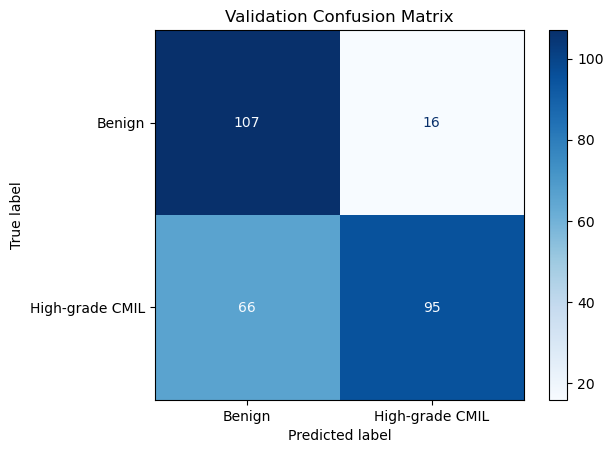

[Epoch 2]: 100%|██████████| 7/7 [05:18<00:00, 45.52s/it]


Epoch 2, Training Loss: 0.1559

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.76      0.89      0.82       123
High-grade CMIL       0.90      0.79      0.84       161

       accuracy                           0.83       284
      macro avg       0.83      0.84      0.83       284
   weighted avg       0.84      0.83      0.83       284



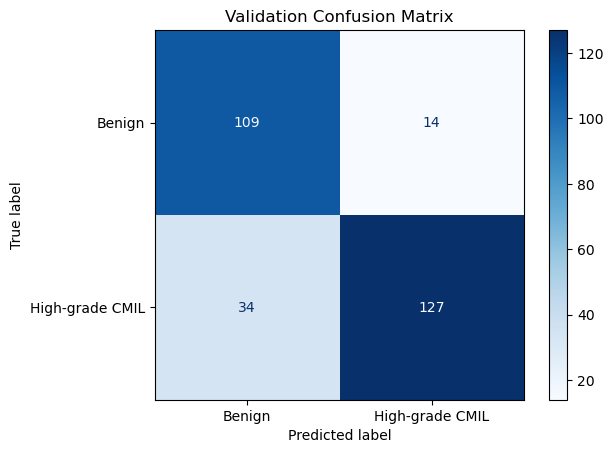

[Epoch 3]: 100%|██████████| 7/7 [04:20<00:00, 37.19s/it]


Epoch 3, Training Loss: 0.1339

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.84      0.79      0.81       123
High-grade CMIL       0.85      0.88      0.86       161

       accuracy                           0.84       284
      macro avg       0.84      0.84      0.84       284
   weighted avg       0.84      0.84      0.84       284



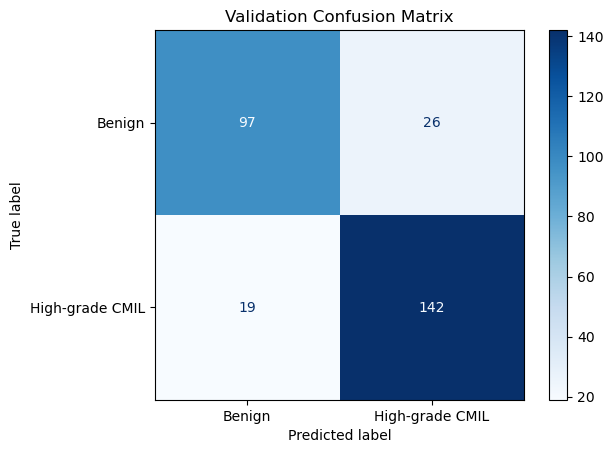

[Epoch 4]: 100%|██████████| 7/7 [05:57<00:00, 51.00s/it]


Epoch 4, Training Loss: 0.0838

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.84      0.58      0.68       123
High-grade CMIL       0.74      0.91      0.82       161

       accuracy                           0.77       284
      macro avg       0.79      0.75      0.75       284
   weighted avg       0.78      0.77      0.76       284



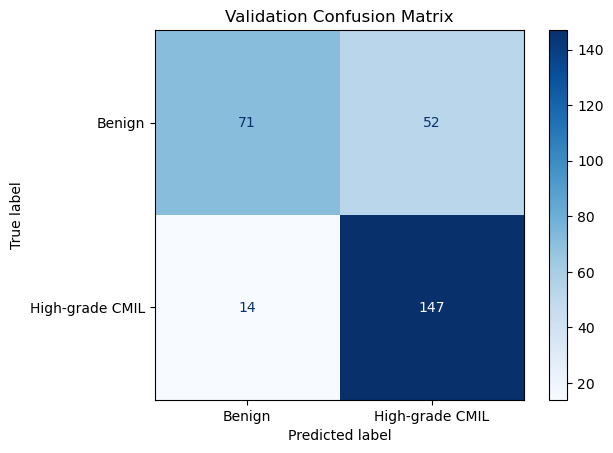

[Epoch 5]: 100%|██████████| 7/7 [06:12<00:00, 53.18s/it]


Epoch 5, Training Loss: 0.0677

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.81      0.51      0.63       123
High-grade CMIL       0.71      0.91      0.80       161

       accuracy                           0.74       284
      macro avg       0.76      0.71      0.71       284
   weighted avg       0.75      0.74      0.72       284



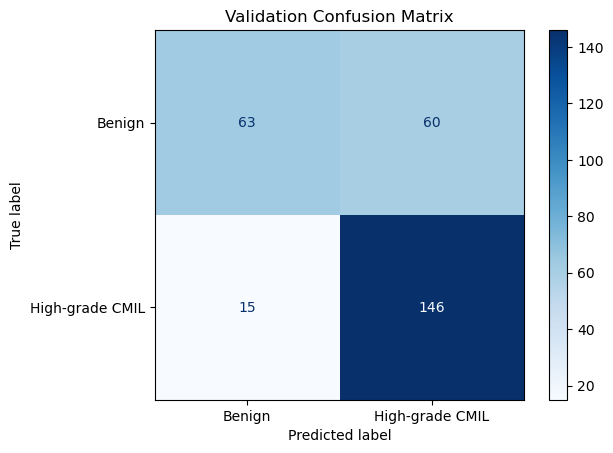

[Epoch 6]: 100%|██████████| 7/7 [03:25<00:00, 29.35s/it]


Epoch 6, Training Loss: 0.0479

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.82      0.55      0.66       123
High-grade CMIL       0.73      0.91      0.81       161

       accuracy                           0.75       284
      macro avg       0.77      0.73      0.73       284
   weighted avg       0.77      0.75      0.74       284



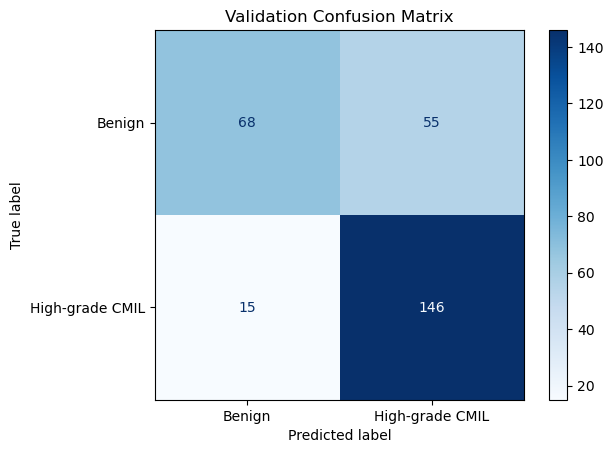

[Epoch 7]: 100%|██████████| 7/7 [03:08<00:00, 26.97s/it]


Epoch 7, Training Loss: 0.0382

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.82      0.65      0.73       123
High-grade CMIL       0.77      0.89      0.83       161

       accuracy                           0.79       284
      macro avg       0.80      0.77      0.78       284
   weighted avg       0.79      0.79      0.78       284



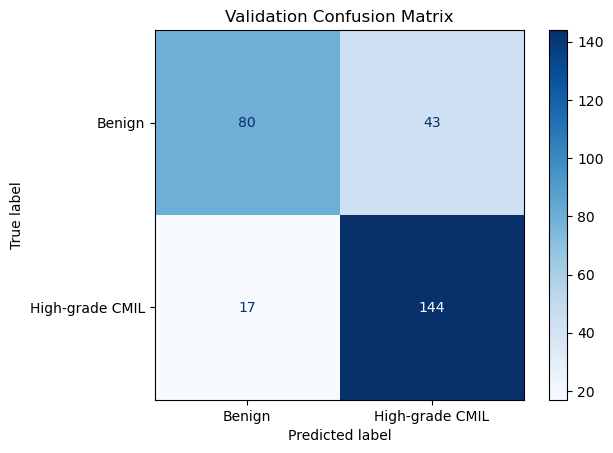

[Epoch 8]: 100%|██████████| 7/7 [03:16<00:00, 28.07s/it]


Epoch 8, Training Loss: 0.0447

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.84      0.66      0.74       123
High-grade CMIL       0.78      0.90      0.83       161

       accuracy                           0.80       284
      macro avg       0.81      0.78      0.78       284
   weighted avg       0.80      0.80      0.79       284



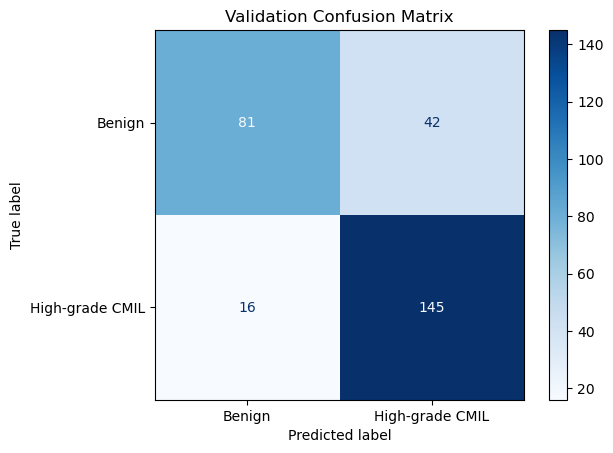

[Epoch 9]: 100%|██████████| 7/7 [03:06<00:00, 26.67s/it]


Epoch 9, Training Loss: 0.0343

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.83      0.70      0.76       123
High-grade CMIL       0.80      0.89      0.84       161

       accuracy                           0.81       284
      macro avg       0.82      0.80      0.80       284
   weighted avg       0.81      0.81      0.81       284



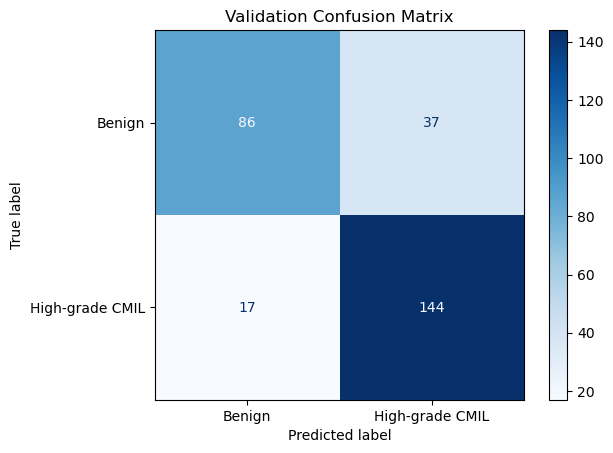

[Epoch 10]: 100%|██████████| 7/7 [03:08<00:00, 26.94s/it]


Epoch 10, Training Loss: 0.0190

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.85      0.72      0.78       123
High-grade CMIL       0.81      0.90      0.85       161

       accuracy                           0.82       284
      macro avg       0.83      0.81      0.81       284
   weighted avg       0.82      0.82      0.82       284



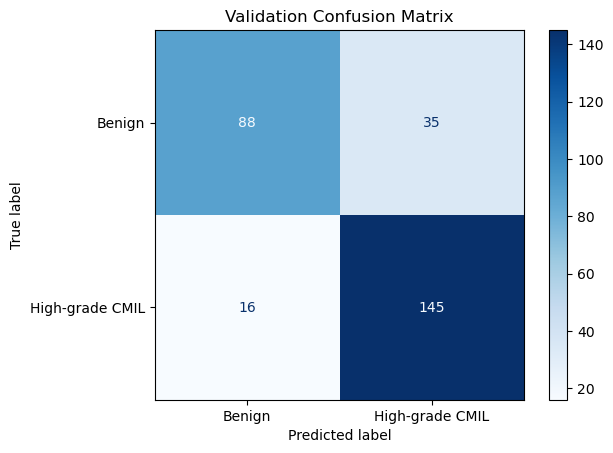


=== Test Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.73      0.84      0.78       621
High-grade CMIL       0.79      0.65      0.72       565

       accuracy                           0.75      1186
      macro avg       0.76      0.75      0.75      1186
   weighted avg       0.76      0.75      0.75      1186



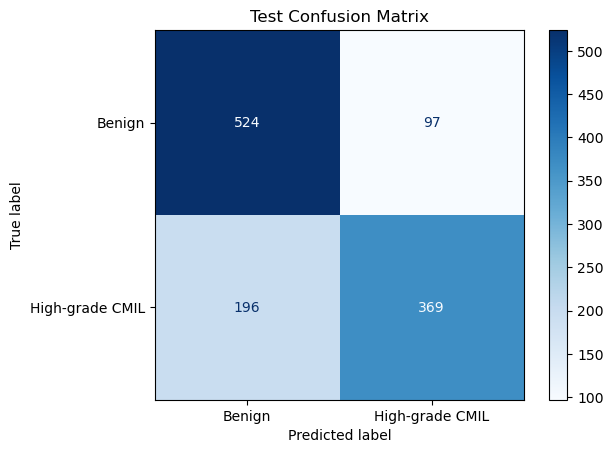

In [32]:
train_patch_classifier(patch_model, train_loader, val_loader, patch_criterion, patch_optimizer, device, epochs=10)
evaluate_patch_classifier(patch_model, test_loader, device, "Test")

In [33]:
# Save model checkpoint
os.makedirs(checkpoint_dir, exist_ok=True)
patch_model_path = os.path.join(checkpoint_dir, "patch_classifier.pth")
torch.save(patch_model.state_dict(), patch_model_path)
print(f"✅ Patch model saved to: {patch_model_path}")

✅ Patch model saved to: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/patch_classifier.pth



=== Patch-Level Classification Report (PatchClassifier) ===
                 precision    recall  f1-score   support

         Benign       0.73      0.84      0.78       621
High-grade CMIL       0.79      0.65      0.72       565

       accuracy                           0.75      1186
      macro avg       0.76      0.75      0.75      1186
   weighted avg       0.76      0.75      0.75      1186



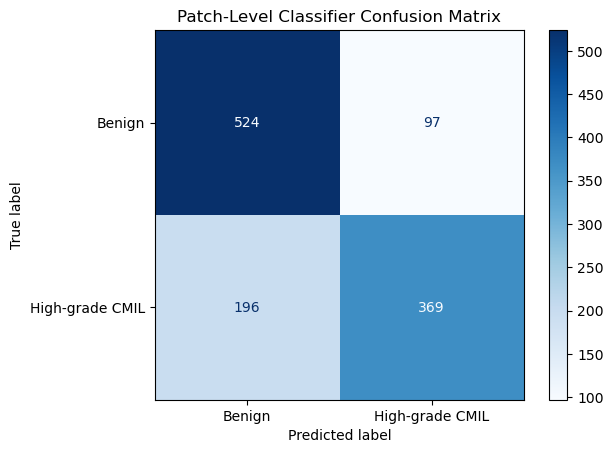

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_patch_model(model, test_loader, device):
    model.eval()
    all_preds, all_trues = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(labels.numpy())

    print("\n=== Patch-Level Classification Report (PatchClassifier) ===")
    print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

    # Confusion Matrix
    cm = confusion_matrix(all_trues, all_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'High-grade CMIL'])
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Patch-Level Classifier Confusion Matrix")
    plt.show()

evaluate_patch_model(patch_model, test_loader, device)